## Shape recognition 

In [1]:
import numpy as np
import json
import pickle


## Load training data

In [2]:
seq_length=100
img_size=20


def normalize_points(lpoints):
    p=np.array(lpoints)
    p=p-p.min(axis=0)
    return p/(p.max()+0.01)

def iter_training():
    for line in open("whiteboard/data/training.json"):
        obj=json.loads(line.strip())
        yield obj["shape"],obj["points"]

def iter_normalized():
    for shape,points in iter_training():
        if shape!="?" and len(points)>20:
            yield shape,normalize_points(points)

def iter_sequences(size):
    for shape,points in iter_normalized():
        seq=np.array(lpoints[:size])
        if len(lpoints)<size:
            seq=np.pad(seq,pad_width=( (0,size-len(lpoints)) , (0,0) ), mode="edge")
        yield shape,seq

hsymetry={"rectangle":"rectangle","elispse":"elispse",
          "leftbracket":"leftbracket","rightbracket":"rightbracket",
          "sigma":"sigma","leftarrow":"leftarrow","rightarrow":"rightarrow",
          "uparrow":"downarrow","downarrow":"uparrow",
          "hline":"hline","vline":"vline","upline":"downline","downline":"upline"}


vsymetry={"rectangle":"rectangle","elispse":"elispse","triangle":"triangle",
          "leftbracket":"rightbracket","rightbracket":"leftbracket",
          "leftarrow":"rightarrow","rightarrow":"leftarrow",
          "uparrow":"uparrow","downarrow":"downarrow",
          "hline":"hline","vline":"vline","upline":"downline","downline":"upline"}



def enrich_image(shape,img):
    yield shape,img
    
    #horizontal symetry
    if shape in hsymetry:
        yield hsymetry[shape],np.flipud(img)

    #vertical symetry
    if shape in vsymetry:
        yield vsymetry[shape],np.fliplr(img)

def iter_images():
    for shape,points in iter_normalized():
        img=np.zeros((img_size,img_size))
        for y,x in np.rollaxis(points, 0):
            img[int(x*img_size),int(y*img_size)]=1.0
        for shape1,img1 in enrich_image(shape,img):
            yield shape1,img1.reshape(img_size,img_size,1)


In [3]:
def point_sampling(seq,size):
    ratio=float(len(seq)-1)/(size-1)
    for i in range(size):
        position=int(np.trunc(i*ratio))
        residual=i*ratio-position
        if position<len(seq)-1:
            x0,y0=seq[position]
            x1,y1=seq[position+1]
            x=int(x0+(x1-x0)*residual)
            y=int(y0+(y1-y0)*residual)
            yield (x,y)
        else:
            yield seq[-1]


In [4]:
for p in point_sampling([(0,0),(10,10),(300,200),(200,100),(50,50),(70,70)],13):
    print(p)

(0, 0)
(4, 4)
(8, 8)
(82, 57)
(203, 136)
(291, 191)
(250, 150)
(208, 108)
(149, 83)
(87, 62)
(53, 53)
(61, 61)
(70, 70)


In [5]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,Flatten,MaxPool2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
X=np.array([p for _,p in iter_images() ])
X.shape

(2432, 20, 20, 1)

In [7]:
yLabel=[label for label,_ in iter_images() ]
labelEncoder=LabelEncoder().fit(yLabel)
num_classes=len(labelEncoder.classes_)
y=to_categorical(labelEncoder.transform(yLabel))
y.shape

(2432, 15)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [9]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(4,4),activation='relu',input_shape=(img_size,img_size,1)))
#model.add(Conv2D(16, kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1,1), padding='valid'))
model.add(Flatten())
model.add(Dropout(0.2)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 17, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1

In [10]:
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.3),
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=10, epochs=20,verbose=1, validation_data=(X_test,y_test))
score = model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
195/195 [==============================] - 2s 10ms/step - loss: 1.9984 - accuracy: 0.6668 - val_loss: 1.6628 - val_accuracy: 0.8563
Epoch 2/20
195/195 [==============================] - 2s 9ms/step - loss: 1.6301 - accuracy: 0.9049 - val_loss: 1.5620 - val_accuracy: 0.9117
Epoch 3/20
195/195 [==============================] - 2s 13ms/step - loss: 1.5263 - accuracy: 0.9599 - val_loss: 1.5063 - val_accuracy: 0.9425
Epoch 4/20
195/195 [==============================] - 2s 12ms/step - loss: 1.4838 - accuracy: 0.9830 - val_loss: 1.4995 - val_accuracy: 0.9507
Epoch 5/20
195/195 [==============================] - 2s 10ms/step - loss: 1.4613 - accuracy: 0.9913 - val_loss: 1.4845 - val_accuracy: 0.9610
Epoch 6/20
195/195 [==============================] - 2s 11ms/step - loss: 1.4428 - accuracy: 0.9949 - val_loss: 1.4727 - val_accuracy: 0.9589
Epoch 7/20
195/195 [==============================] - 2s 12ms/step - loss: 1.4332 - accuracy: 0.9959 - val_loss: 1.4705 - val_accuracy: 0.9528


In [11]:
import pandas as pd
df=pd.DataFrame(history.history)
_=df.plot(kind="line",subplots=(2,2),figsize=(10,10),layout=(2,2))

In [12]:
modelDir="whiteboard/model"
model.save(modelDir)

pickle.dump(labelEncoder,open(modelDir+"/assets/labelEncoder.pickle","wb"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: whiteboard/model/assets


In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
predictions=model.predict(X)
predictedLabels=labelEncoder.inverse_transform(predictions.argmax(axis=1))

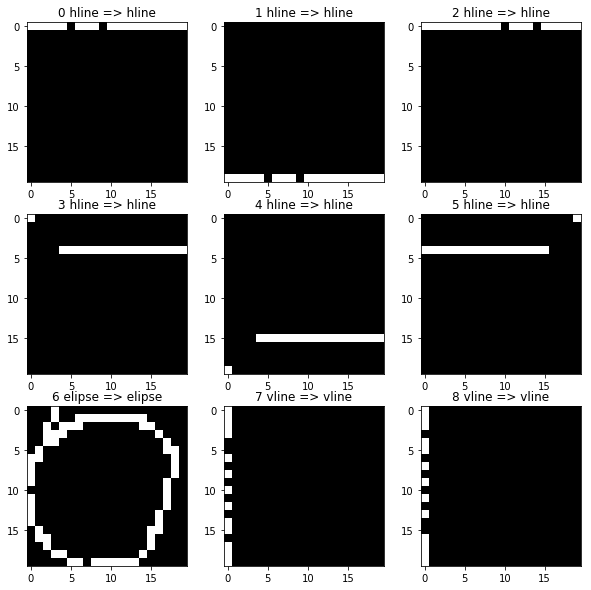

In [15]:
def show_plot(indices):
    plt.figure(figsize=(10,10))
    for p,i in enumerate(indices[:9]):
        plt.subplot(3,3,p+1)
        plt.imshow(X[i].reshape(img_size,img_size), cmap='gray', interpolation='none')
        plt.title("{} {} => {}".format(i,yLabel[i],predictedLabels[i]))

show_plot(range(9))

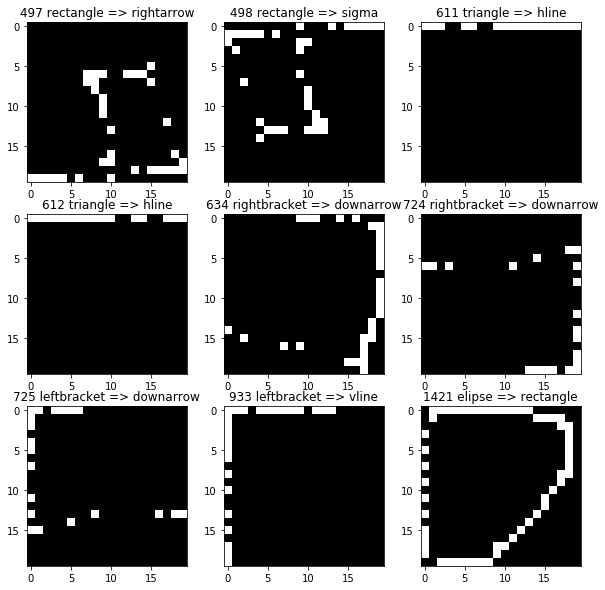

In [16]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

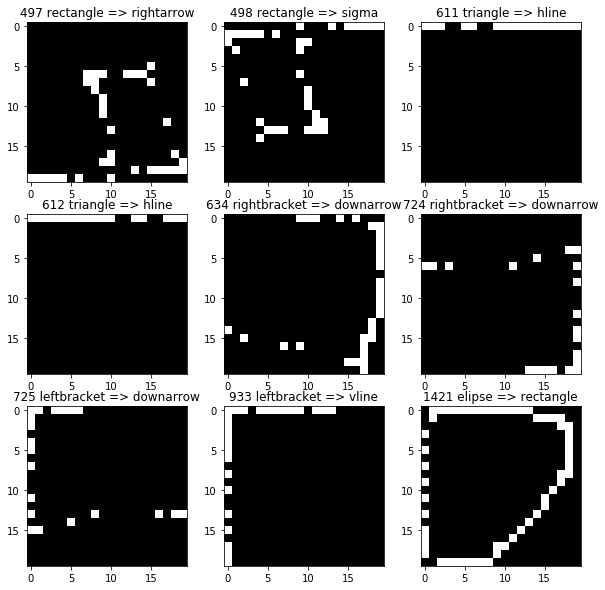

In [17]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

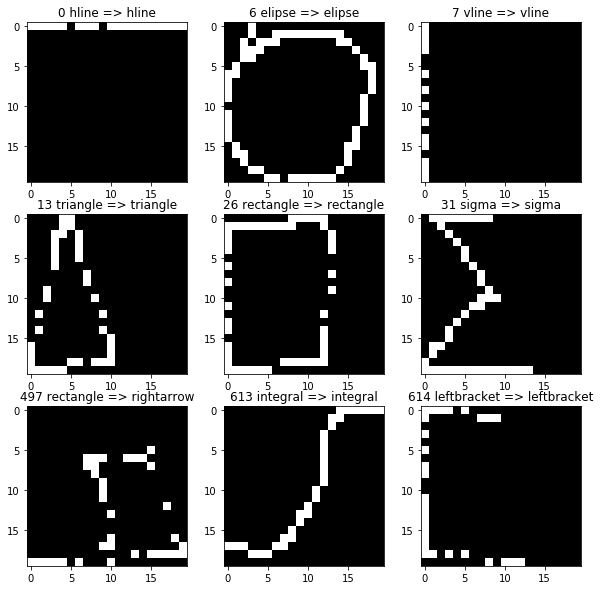

In [18]:
indices=[]
foundclasses=set(predictedLabels)
for i,c in enumerate(predictedLabels):
    if c in foundclasses:
        indices.append(i)
        foundclasses.remove(c)

show_plot(indices)

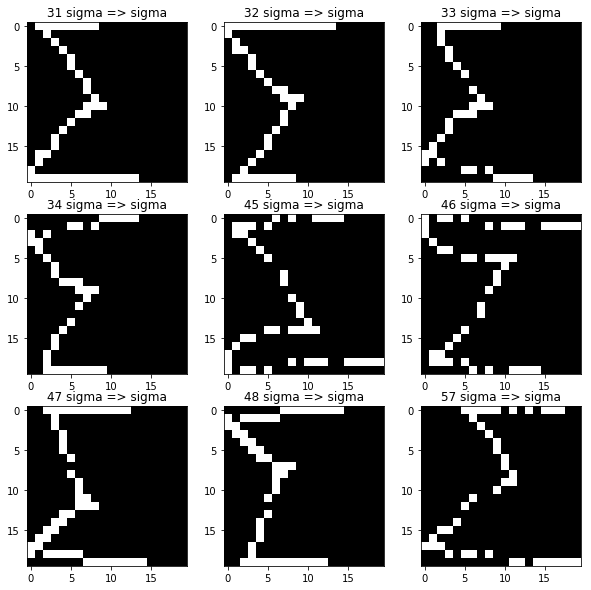

In [19]:
indices=[i for i,good in enumerate(predictedLabels=="sigma") if good]
show_plot(indices)

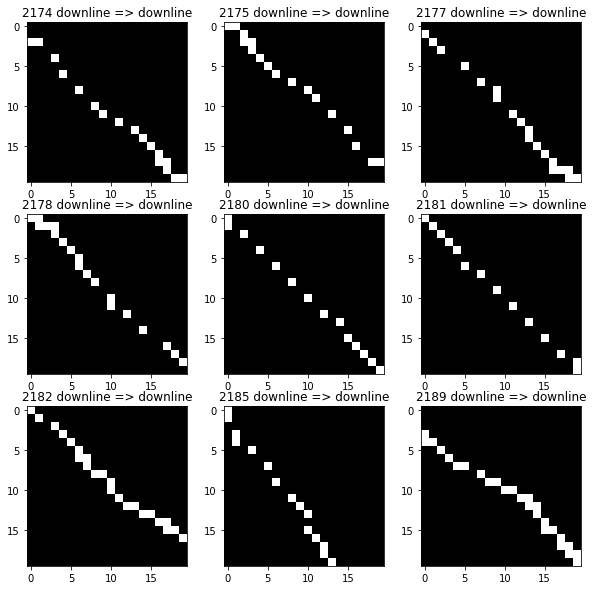

In [20]:
indices=[i for i,label in enumerate(yLabel) if label=="downline"]
show_plot(indices)

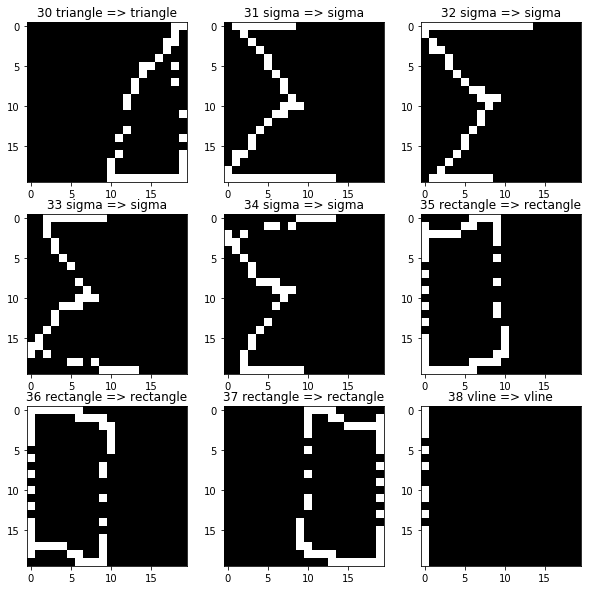

In [21]:
start=30
indices=range(start,start+9)
show_plot(indices)

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yLabel, predictedLabels)

cm=cm/np.sum(cm,axis=1)


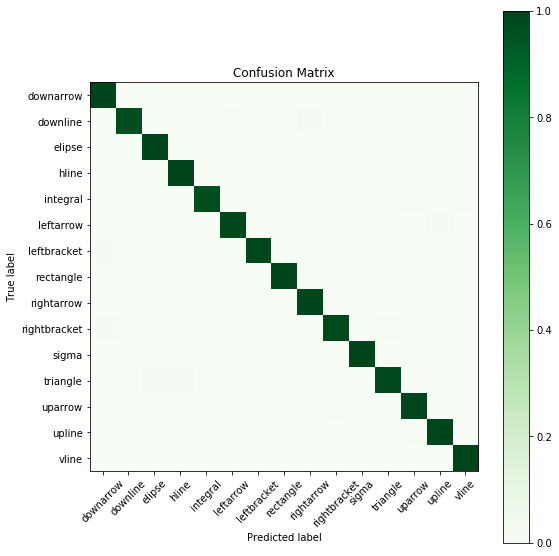

In [41]:
def print_confusion_matrix(cm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, labelEncoder.classes_,rotation=45)
    plt.yticks(tick_marks, labelEncoder.classes_)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
print_confusion_matrix(cm)

In [221]:
def line(img,fromPoint,toPoint):
    xfrom,yfrom = fromPoint
    xto,yto = toPoint
    midPoint=((xfrom+xto)/2,(yfrom+yto)/2)
    img[int(midPoint[1]-0.5),int(midPoint[0]-0.5)]=1
    if xto > xfrom+1 or yto > yfrom+1:
        line(img,fromPoint,midPoint)
        line(img,midPoint,toPoint)

def draw_shape(shape,img_size):
    img=np.zeros((img_size,img_size))
    if shape=="hline":
        line(img,(0,0),(img_size,0))
    elif shape=="vline":
        line(img,(0,0),(0,img_size))
    elif shape=="upline":
        line(img,(0,img_size),(img_size,0))
    elif shape=="downline":
        line(img,(0,0),(img_size,img_size))
    elif shape=="rectangle":
        line(img,(0,0),(img_size,0))
        line(img,(0,img_size),(img_size,img_size))
        line(img,(0,0),(0,img_size))
        line(img,(img_size,0),(img_size,img_size))
    elif shape=="elipse":
        for angle in range(360):
            angleRad=angle*np.pi/180
            img[int((1+np.sin(angleRad))*img_size/2-0.5),int((1+np.cos(angleRad))*img_size/2-0.5)]=1
    elif shape=="triangle":
        line(img,(0,img_size),(img_size/2,0))
        line(img,(img_size/2,0),(img_size,img_size))
        line(img,(0,img_size),(img_size,img_size))
    elif shape=="sigma":
        line(img,(0,0),(img_size,0))
        line(img,(0,0),(img_size/2,img_size/2))
        line(img,(0,img_size),(img_size/2,img_size/2))
        line(img,(0,img_size),(img_size,img_size))
    elif shape=="integral":
        line(img,(0,img_size),(img_size/3,img_size*7/8))
        line(img,(img_size/3,img_size*7/8),(img_size*2/3,img_size/8))
        line(img,(img_size*2/3,img_size/8),(img_size,0))
    elif shape=="leftbracket":
        line(img,(0,0),(img_size/2,0))
        line(img,(0,0),(0,img_size))
        line(img,(0,img_size),(img_size/2,img_size))
    elif shape=="rightbracket":
        line(img,(img_size/2,0),(img_size,0))
        line(img,(img_size,0),(img_size,img_size))
        line(img,(img_size/2,img_size),(img_size,img_size))
    elif shape=="leftarrow":
        line(img,(0,img_size/2),(img_size,0))
        line(img,(0,img_size/2),(img_size,img_size))
    elif shape=="rightarrow":
        line(img,(0,0),(img_size,img_size/2))
        line(img,(0,img_size),(img_size,img_size/2))
    elif shape=="uparrow":
        line(img,(0,img_size),(img_size/2,0))
        line(img,(img_size/2,0),(img_size,img_size))
    elif shape=="downarrow":
        line(img,(0,0),(img_size/2,img_size))
        line(img,(img_size/2,img_size),(img_size,0))
    elif shape=="equal":
        line(img,(0,0),(img_size,0))
        line(img,(0,img_size/2),(img_size,img_size/2))
    elif shape=="x":
        line(img,(0,0),(img_size,img_size))
        line(img,(0,img_size),(img_size,0))





    return img.reshape(img_size,img_size,1)

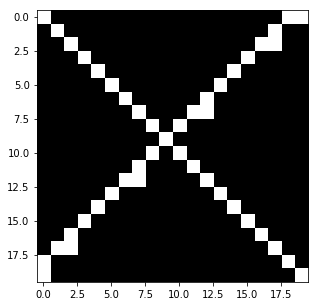

In [222]:
def show_image(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray', interpolation='none')

show_image(draw_shape("x",20).reshape(img_size,img_size))

In [174]:
y_decoder=np.array([draw_shape(shape,img_size) for shape in yLabel])
y_decoder.shape

(2432, 20, 20, 1)

In [175]:
Xenc_train, Xenc_test, yenc_train, yenc_test = train_test_split(X, y_decoder, test_size=0.20)

## Encoder Decoder
Now we extend the model by using an __encoder/decoder__ technic to see if we can create some new design

In [245]:
from tensorflow.keras.layers import Input,Conv2DTranspose,Reshape
from tensorflow.keras.models import  Model
from tensorflow.keras.backend import  int_shape

latent_size=64
kernel_size=3

In [246]:
inputs=Input(shape=(img_size,img_size,1))
x=Conv2D(32, kernel_size=kernel_size,activation='relu')(inputs)
x=Conv2D(16, kernel_size=kernel_size,activation='relu')(x)
shapes=int_shape(x)
x=Flatten()(x)
latent=Dense(latent_size)(x)

encoder=Model(inputs,latent,name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 20, 20, 1)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
flatten_11 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                262208    
Total params: 267,152
Trainable params: 267,152
Non-trainable params: 0
_________________________________________________________________


In [247]:
latent_input=Input(shape=(latent_size, ))

x=Dense(np.prod(shapes[1:]),input_shape=(latent_size,))(latent_input)
x=Reshape(((shapes[1:])))(x)
x=Conv2DTranspose(16, kernel_size=kernel_size,activation='relu')(x)
x=Conv2DTranspose(32, kernel_size=kernel_size,activation='relu')(x)
output=Conv2DTranspose(1, kernel_size=kernel_size,padding="same",activation='sigmoid')(x)
decoder=Model(latent_input,output,name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
dense_27 (Dense)             (None, 4096)              266240    
_________________________________________________________________
reshape_13 (Reshape)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 18, 18, 16)        2320      
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 20, 20, 32)        4640      
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 20, 20, 1)         289       
Total params: 273,489
Trainable params: 273,489
Non-trainable params: 0
_____________________________________________________

In [248]:
autoencoder=Model(inputs,decoder(encoder(inputs)),name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 20, 20, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 64)                267152    
_________________________________________________________________
decoder (Functional)         (None, 20, 20, 1)         273489    
Total params: 540,641
Trainable params: 540,641
Non-trainable params: 0
_________________________________________________________________


In [249]:
autoencoder.compile(loss="mse",
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])
history=autoencoder.fit(Xenc_train, yenc_train, batch_size=10, epochs=20,verbose=1, 
                  validation_data=(Xenc_test,yenc_test))



Epoch 1/20
195/195 [==============================] - 4s 20ms/step - loss: 0.1108 - accuracy: 0.8768 - val_loss: 0.0897 - val_accuracy: 0.8847
Epoch 2/20
195/195 [==============================] - 4s 20ms/step - loss: 0.0820 - accuracy: 0.8920 - val_loss: 0.0650 - val_accuracy: 0.9147
Epoch 3/20
195/195 [==============================] - 3s 18ms/step - loss: 0.0512 - accuracy: 0.9349 - val_loss: 0.0428 - val_accuracy: 0.9462
Epoch 4/20
195/195 [==============================] - 4s 20ms/step - loss: 0.0311 - accuracy: 0.9624 - val_loss: 0.0305 - val_accuracy: 0.9630
Epoch 5/20
195/195 [==============================] - 4s 21ms/step - loss: 0.0204 - accuracy: 0.9757 - val_loss: 0.0244 - val_accuracy: 0.9703
Epoch 6/20
195/195 [==============================] - 4s 21ms/step - loss: 0.0147 - accuracy: 0.9832 - val_loss: 0.0217 - val_accuracy: 0.9740
Epoch 7/20
195/195 [==============================] - 4s 19ms/step - loss: 0.0103 - accuracy: 0.9885 - val_loss: 0.0184 - val_accuracy: 0.9780

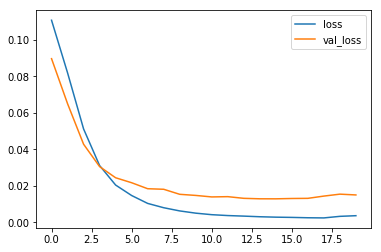

In [250]:
def show_history(mettype):
    for metric in (mettype,"val_"+mettype):
        plt.plot(history.history[metric],label=metric)
    _=plt.legend()
show_history("loss")

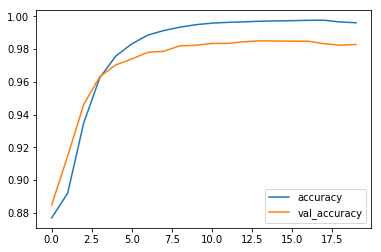

In [251]:
show_history("accuracy")

In [217]:
predictions=autoencoder.predict(X[-25:])

In [207]:
predictions.shape

(25, 20, 20, 1)

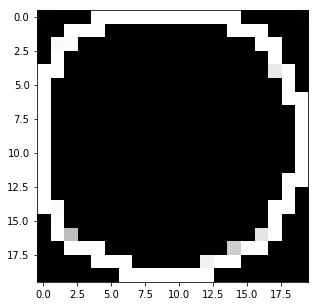

In [219]:
show_image(predictions[13].reshape(img_size,img_size))

In [205]:
yLabel[-25:]

['rightbracket',
 'leftbracket',
 'leftbracket',
 'leftbracket',
 'rightbracket',
 'rightbracket',
 'rightbracket',
 'leftbracket',
 'sigma',
 'sigma',
 'uparrow',
 'downarrow',
 'uparrow',
 'elipse',
 'rectangle',
 'rectangle',
 'rectangle',
 'leftarrow',
 'leftarrow',
 'rightarrow',
 'sigma',
 'sigma',
 'rightbracket',
 'rightbracket',
 'leftbracket']

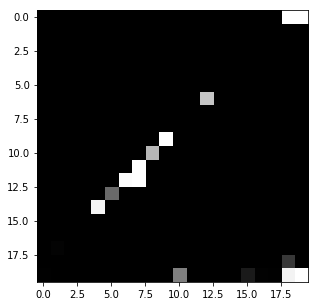

In [223]:
predictions=model.predict(draw_shape("x",img_size).reshape(1,img_size,img_size,1))
show_image(predictions[0].reshape(img_size,img_size))